In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

For my machine learning notebook I will be using unsupervised learning, I have opted for this method as there is no target variable to predict. The primary focus is to discover patterns in the data, in this case student's use of social media. These patterns could then be further analysed and used by social media companies who want to target certain demographics, or health professionals looking for causation of poor mental health scores.

Before I can run the data through my ml model I will have to modify the data and select the optimal number of clusters.

## 1.1 Load and inspect the dataset

In [72]:
# Load the data
df_ml = pd.read_csv('../data/cleaned_data/student_social_media_addiction_cleaned.csv')

## 1.2 Column management

Not all columns will be used in the model, some of the time columns are too similar to each other so I will be dropping the hour columns and using the minute ones going forward.

In [73]:
# Check column names to assign them as numerical or categorical
df_ml.columns

Index(['new_student_id', 'age', 'gender', 'relationship_status',
       'academic_level', 'country', 'continents', 'most_used_platform',
       'average_daily_usage_minutes', 'average_daily_use_by_hour',
       'sleep_per_night_minutes', 'sleep_hours_per_night',
       'conflicts_over_social_media', 'affects_academic_performance',
       'addicted_score', 'mental_health_score'],
      dtype='object')

In [ ]:
# Drop unnecessary columns
df_ml = df_ml.drop(columns=['new_student_id', 'average_daily_use_by_hour', 'sleep_hours_per_night'])

In [75]:
# Numerical and categorical columns
num_cols = ['age', 'average_daily_usage_minutes', 'sleep_per_night_minutes', 'conflicts_over_social_media', 'addicted_score', 'mental_health_score']
cat_cols = ['gender', 'relationship_status', 'academic_level', 'country', 'continents', 'most_used_platform', 'affects_academic_performance']

## 1.3 Encode categoricals and scale numerical columns
I will need to encode the categorical ones from string to numerical so that they are useable. Numerical columns will also be scaled so that they do not distort the data. Standard scaler gives all columns a mean of 0 and standard deviation of 1. 

In [76]:
# Encode categoricals and scale numerical columns
preprocessor = ColumnTransformer([
    ('numeric', StandardScaler(), num_cols),
    ('categorical', OneHotEncoder(drop='first', sparse_output=False), cat_cols)
])

## 1.4 Create pipeline - to be refined
A pipeline has been created and will be refined throughout this notebook to get the best clusters. By using a pipeline multiple steps can be bundled together to transform and model the data, reducing errors and making it reusable. Pipelines are useful when experimenting with different PCA components or cluster numbers to efficiently refine the analysis.
As I have already cleaned the data in a previous notebook I will not be including a data cleaning or feature engineering step in this pipeline. 

The preprocessor has been created in the cell scaling the numerical columns. Categorical columns have then been encoded, the first value has been dropped for efficiency. The PCA components and kmeans are still to be refined to both have been set to 10.

In [ ]:
# Create pipeline

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=10)),
    ('kmeans', KMeans(n_clusters=10, random_state=42))
])

Here we are trying to find the optimal number of principal components. The default number gives us a result of 86.14% meaning they summarise most of the data but have discarded some values. We are aiming to get a value between 85-95% with as few as components as possible.

In [ ]:
# Apply preprocessor to the data
X_processed = preprocessor.fit_transform(df_ml)

# Define range of n_components to test
component_range = range(9, 14)

results = {}

for n_components in component_range:
    pca = PCA(n_components=n_components).fit(X_processed)
    explained_variance = np.round(100 * pca.explained_variance_ratio_.sum(), 2)
    results[n_components] = explained_variance

df_variance_summary = pd.DataFrame.from_dict(
    results, orient='index', columns=['Explained Variance (%)']
)
df_variance_summary.index.name = 'Number of Components'

print(df_variance_summary)

                      Explained Variance (%)
Number of Components                        
9                                      84.80
10                                     86.14
11                                     87.09
12                                     87.95
13                                     88.77


Looking at those results, the largest jump in variance is from 9 to 10. Adding more than that make little change to the variance but increases dimensionality, something we're trying to reduce. We will be using 10 components as it allows us to retain the majority of the dataset's information and reduce dimensionality to simplify KMeans

In [ ]:
# Update cluster pipeline, n_components to 10

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=10)),
    ('kmeans', KMeans(n_clusters=10, random_state=42))
])

In [100]:
pipeline_analysis = Pipeline(pipeline.steps[:-1])
df_analysis = pipeline_analysis.fit_transform(df_ml)

print(df_analysis.shape, type(df_analysis))

(702, 10) <class 'numpy.ndarray'>


## 1.5 Run elbow method and silhouette score

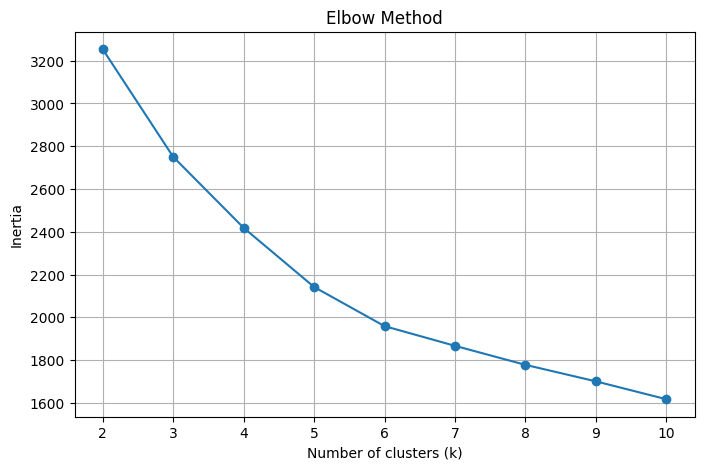

In [106]:
X_pca = pipeline_analysis.fit_transform(df_ml)

sse = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)  # now using the transformed data
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_values, sse, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.grid(True)
plt.savefig('../images/elbow_method.png')
plt.show()

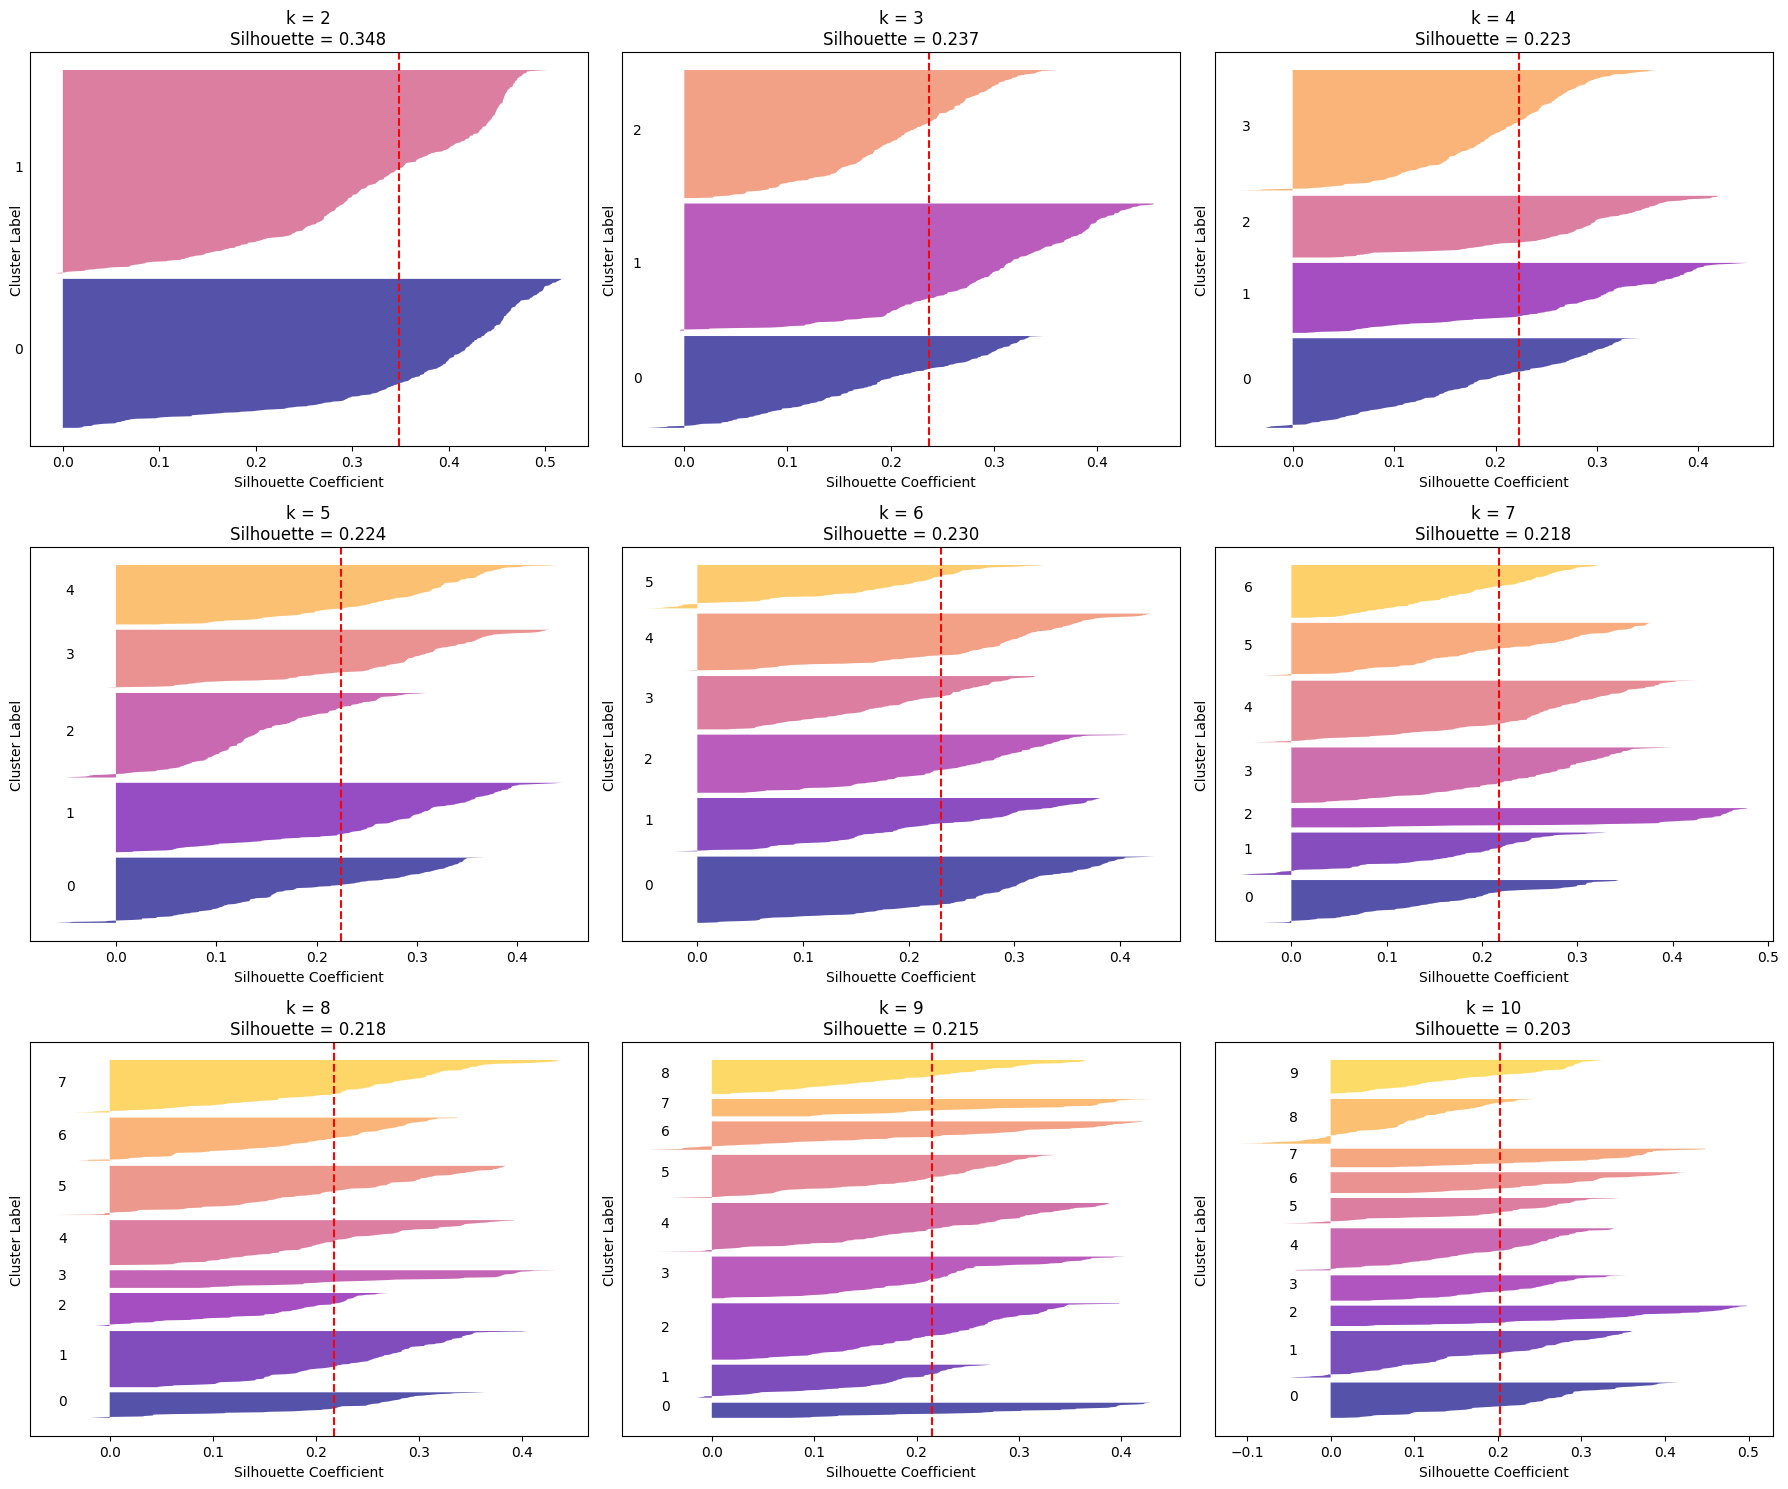

In [105]:
# Testing range of clusters 

k_values = range(2, 11)

n_plots = len(k_values)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten()

for idx, k in enumerate(k_values):
    ax = axes[idx]

    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)

    sample_silhouette_values = silhouette_samples(X_pca, labels)
    avg_silhouette = silhouette_score(X_pca, labels)

    y_lower = 10
    for cluster in range(k):
        cluster_vals = sample_silhouette_values[labels == cluster]
        cluster_vals.sort()
        size_cluster = len(cluster_vals)
        y_upper = y_lower + size_cluster

        color = plt.cm.plasma(float(cluster) / k)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0, cluster_vals,
            facecolor=color,
            alpha=0.7
        )

        ax.text(-0.05, y_lower + 0.5 * size_cluster, str(cluster))
        y_lower = y_upper + 10

    ax.axvline(x=avg_silhouette, color="red", linestyle="--")

    ax.set_title(f"k = {k}\nSilhouette = {avg_silhouette:.3f}")
    ax.set_xlabel("Silhouette Coefficient")
    ax.set_ylabel("Cluster Label")
    ax.set_yticks([])

for j in range(n_plots, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('../images/silhouette_score.png')
plt.show()
